In [2]:
# 구글 드라이버 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 깃헙 동기화 및 경로 설정

In [3]:
%cd /content/drive/MyDrive/Final_project
!git clone https://github.com/Slangoij/PlayData_Final_Project.git
%cd /content/drive/MyDrive/Final_project/PlayData_Final_Project

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project
fatal: destination path 'PlayData_Final_Project' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


# 파라미터 및 데이터 경로 설정

In [5]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 50
N_BATCHS = 50
NUM_CLASSES = 4 # 클래스 개수
INPUT_SHAPE = (224, 224, 3) # 학습할 이미지 shape
CLASS_MODE = 'categorical'
########################### 모델에 맞춰 변경해야 한다!
FEATURE_SHAPE = (20, 15, 512)

BASE_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project'
ORIGINAL_IMG_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/inputdata_preprocessing/img'
AUGMENT_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/inputdata_preprocessing/augmentImg'
train_dir = './inputdata_preprocessing/classedImg/train'
validation_dir = './inputdata_preprocessing/classedImg/val'
test_dir = './inputdata_preprocessing/classedImg/test'

In [6]:
%pwd

'/content/drive/MyDrive'

# 함수:  특성추출, 분류기 모델 생성

In [22]:
def get_generators():
    '''
    train, validation, test generator를 생성해서 반환.
    train generator는 image 변환 처리
    '''
    # 상하좌우 이동, 확대, 회전 이미지로 증강
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       zoom_range = 0.1,
                                       brightness_range=[0.9, 1.1],
                                       fill_mode='nearest')
    data_datagen = ImageDataGenerator(rescale=1./255,) 
    
    test_datagen = ImageDataGenerator(rescale=1/255) #validation/test에서 사용

    # generator 들 생성
    # 첫번째는 먼저 한동작이므로 동작과 비동작으로 바이너리 구분만
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=INPUT_SHAPE[1::-1],
                                                        batch_size=N_BATCHS,
                                                        class_mode=CLASS_MODE)    
    val_generator = test_datagen.flow_from_directory(validation_dir,
                                                     target_size=INPUT_SHAPE[1::-1],
                                                     batch_size=N_BATCHS,
                                                     class_mode=CLASS_MODE)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size=INPUT_SHAPE[1::-1],
                                                      batch_size=N_BATCHS,
                                                      class_mode=CLASS_MODE)
    return train_generator, val_generator, test_generator


# 결과 출력
def plot_result(history, ymin=None, ymax=None):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)

    plt.plot(range(1,N_EPOCHS+1), history.history['loss'], label='train loss')
    plt.plot(range(1,N_EPOCHS+1), history.history['val_loss'], label='validation loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, N_EPOCHS+1), history.history['accuracy'], label='train accuracy')
    plt.plot(range(1, N_EPOCHS+1), history.history['val_accuracy'], label='validation accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.tight_layout()
    plt.show()

# 데이터 증강

In [23]:
%cd /content/drive/MyDrive/Final_project/PlayData_Final_Project

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


# 학습 이미지 디렉토리별 정리

In [27]:
%cd /content/drive/MyDrive/Final_project/PlayData_Final_Project

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


In [28]:
# 학습데이터 및 모델 경로 
ORIGINAL_IMG_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/4cls_prvnxtws_data_img'

train_dir = './inputdata_preprocessing/classedImg/train'
validation_dir = './inputdata_preprocessing/classedImg/val'
test_dir = './inputdata_preprocessing/classedImg/test'

# 기존 데이터 디렉토리 지우기
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(validation_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

img_file_list = os.listdir(ORIGINAL_IMG_PATH)
img_file_list.sort()
for i in range(len(img_file_list)): # 모든 라벨(폴더)마다
  label = img_file_list[i]

  train_under_dir = os.path.join(train_dir, label)
  validation_under_dir = os.path.join(validation_dir, label)
  test_under_dir = os.path.join(test_dir, label)
  
  os.makedirs(train_under_dir, exist_ok=True)
  os.makedirs(validation_under_dir, exist_ok=True)
  os.makedirs(test_under_dir, exist_ok=True)

  tmp_img_path = os.path.join(ORIGINAL_IMG_PATH, label)
  img_list = os.listdir(tmp_img_path)
  train_len = int(len(img_list)*0.7) # 70%를 train으로 넣어줌
  val_len = int(len(img_list)*0.9) # 나머지 20%를 train으로 넣어줌 나머지는 test
  random.shuffle(img_list)

  count = 0
  for img_name in img_list:
      if count < train_len:
        shutil.copy(os.path.join(tmp_img_path , img_name), os.path.join(train_under_dir, img_name)) # 이미지 copy
      elif count < val_len:
        shutil.copy(os.path.join(tmp_img_path , img_name), os.path.join(validation_under_dir, img_name))
      else:
        shutil.copy(os.path.join(tmp_img_path , img_name), os.path.join(test_under_dir, img_name))
      count += 1

# 메인학습

In [29]:
# train, val, test 각 폴더 내 데이터 개수
data_cnts = []
for dirs in [train_dir, validation_dir, test_dir]:
  cnt = 0
  for (path, dir, files) in os.walk(dirs):
    cnt += len(files)
  data_cnts.append(cnt)

data_cnts, img_file_list

([831, 237, 121], ['01next_img', '02previous_img', '03S_img', '04W_img'])

In [32]:
train_iterator, validation_iterator, test_iterator = get_generators()

# 모델 학습 설정 콜백함수
MODEL_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/model/vgg16'
if not os.path.isdir(MODEL_PATH):
  os.makedirs(MODEL_PATH, exist_ok=True)

# 모델 생성
def create_model():
  conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(INPUT_SHAPE))
  conv_base.trainable = False

  model = keras.Sequential()
  model.add(conv_base)
  model.add(layers.GlobalAveragePooling2D())

  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(256))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(128))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

  return model

model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 831 images belonging to 4 classes.
Found 237 images belonging to 4 classes.
Found 121 images belonging to 4 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0       

In [34]:
N_EPOCHS = 50
history = model.fit(train_iterator, epochs=N_EPOCHS,
                    steps_per_epoch=len(train_iterator),
                    validation_data=validation_iterator,
                    validation_steps=len(validation_iterator),
                    )

Epoch 1/50
17/17 [==============================] - 19s 1s/step - loss: 1.5439 - accuracy: 0.3057 - val_loss: 1.3529 - val_accuracy: 0.2363
Epoch 2/50
17/17 [==============================] - 16s 924ms/step - loss: 1.3058 - accuracy: 0.4007 - val_loss: 1.2354 - val_accuracy: 0.2616
Epoch 3/50
17/17 [==============================] - 16s 910ms/step - loss: 1.1613 - accuracy: 0.4633 - val_loss: 1.1144 - val_accuracy: 0.6540
Epoch 4/50
17/17 [==============================] - 15s 889ms/step - loss: 1.0262 - accuracy: 0.5572 - val_loss: 0.9895 - val_accuracy: 0.8481
Epoch 5/50
17/17 [==============================] - 15s 901ms/step - loss: 0.9119 - accuracy: 0.5945 - val_loss: 0.8516 - val_accuracy: 0.7511
Epoch 6/50
17/17 [==============================] - 15s 892ms/step - loss: 0.8351 - accuracy: 0.6366 - val_loss: 0.7412 - val_accuracy: 0.8692
Epoch 7/50
17/17 [==============================] - 15s 896ms/step - loss: 0.7228 - accuracy: 0.6968 - val_loss: 0.6126 - val_accuracy: 0.8945
Ep

In [35]:
# h5형식으로 저장
model_h5_path = os.path.join(MODEL_PATH, 'vgg16_model.h5')
model.save(model_h5_path, save_format='h5')

# evaluation
model.evaluate(validation_iterator)
model.evaluate(test_iterator)

3/3 [==============================] - 1s 210ms/step - loss: 0.0708 - accuracy: 0.9752


[0.07078184932470322, 0.9752066135406494]

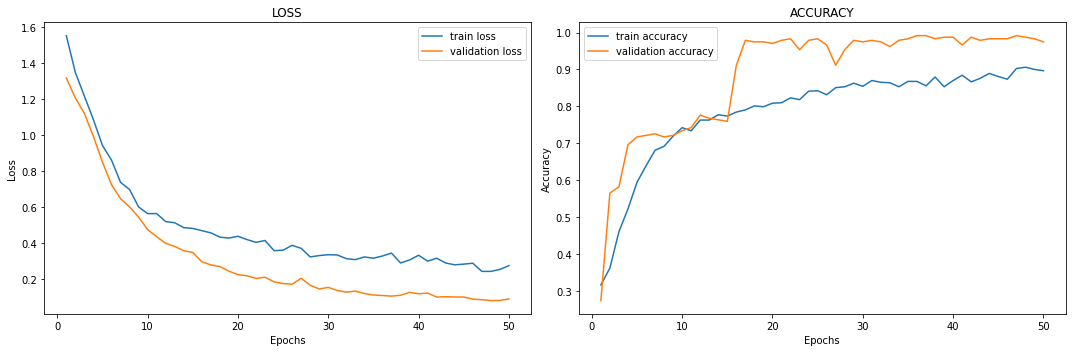

In [21]:
plot_result(history)